In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image

# Загрузка модели

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), 'float32') 
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), 'float32') 
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9  

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def focal_dice_loss(y_true, y_pred, alpha=0.25, gamma=2):
    dice = dice_coefficient(y_true, y_pred)  
    focal_dice = alpha * K.pow(1 - dice, gamma)  
    return 1 - dice + focal_dice

lr_scheduler = LearningRateScheduler(scheduler)
optimizer = Adam(learning_rate=0.0001)

In [3]:
from tensorflow.keras.models import load_model

model_tree = load_model('models\\unet++_vegetation_median_blur_binary_256_100.h5', custom_objects={
    'dice_coefficient': dice_coefficient,
    'iou': iou,
    'dice_loss': dice_loss,
    'focal_dice_loss': focal_dice_loss
})

model_buildings = load_model('models\\unet++_buildings_median_blur_binary_256_250.h5', custom_objects={
    'dice_coefficient': dice_coefficient,
    'iou': iou,
    'dice_loss': dice_loss,
    'focal_dice_loss': focal_dice_loss
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
(1, 256, 256, 1)


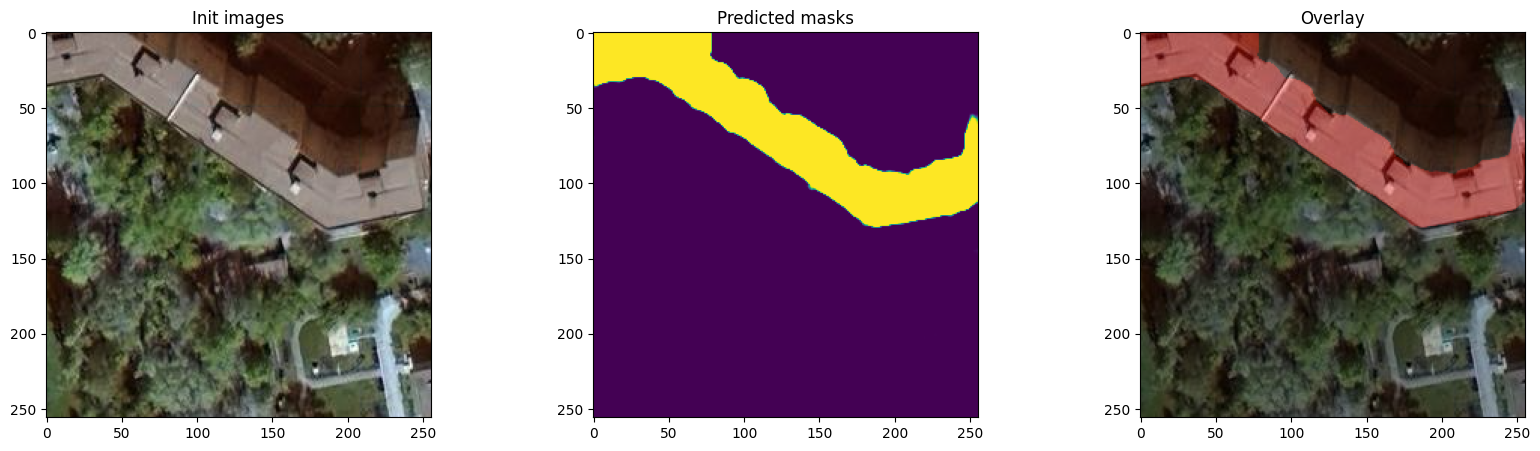

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
(1, 256, 256, 1)


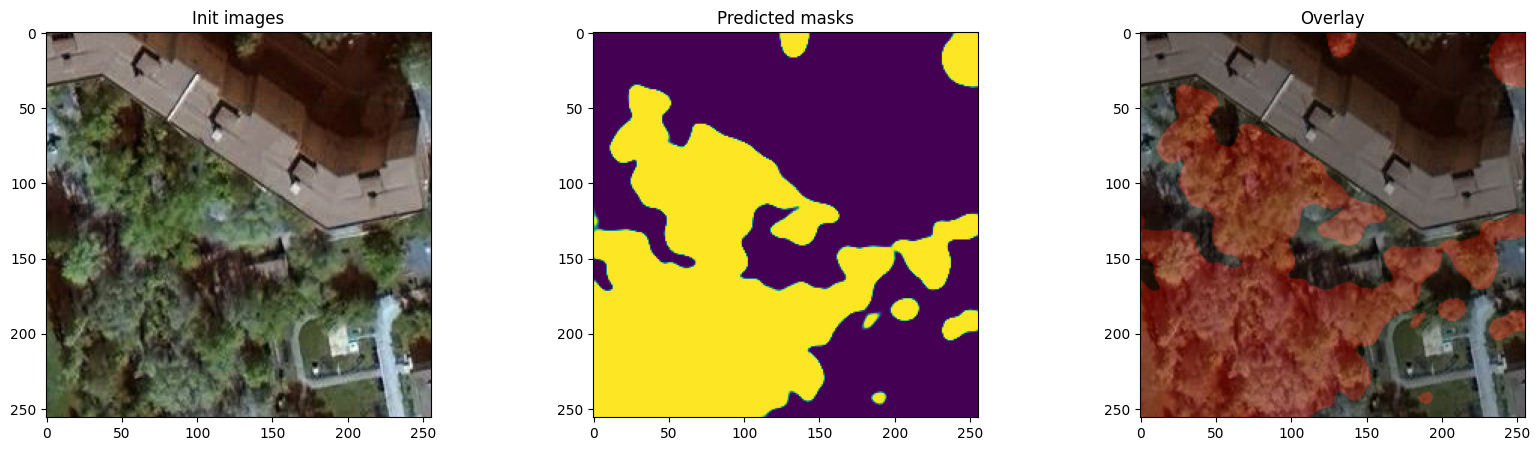

In [ ]:
def predict(image, model):
    preds = model.predict(image)
    return preds

def visualize_predictions(image, buildings_mask):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    print(buildings_mask.shape)
    ax[0].imshow(image[0])
    ax[0].set_title("Init images")
    
    ax[1].imshow(buildings_mask[0])
    mask_color = np.array([1, 0, 0])  
    alpha = 0.3  
    ax[1].set_title("Predicted masks")
    color_mask = buildings_mask * mask_color  
    overlay = image * (1 - alpha) + color_mask * alpha  
    ax[2].set_title("Overlay")
    ax[2].imshow(overlay[0])

    plt.show()

path = 'check\\init_check.png'

image = tf.io.read_file(path)
image = tf.image.decode_png(image, channels=3)
image = tf.cast(image, tf.uint8).numpy()
image = image[:, :, ::-1]
image = np.array(image) / 255.0
image = np.array([image])

build_mask = predict(image, model_buildings)
visualize_predictions(image, build_mask)

build_mask = predict(image, model_tree)
visualize_predictions(image, build_mask)

# Разбитие исходного изображения на блоки, предсказание и дальнейшее склеивание

In [ ]:
def split_image(image_path, model, tile_size=256):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.uint8).numpy()
    median_blurred_image = cv2.medianBlur(image, 5) 
    image = median_blurred_image[:, :, ::-1]
    image = Image.fromarray(image)
    image_width, image_height = image.size

    tiles = []

    for top in range(0, image_height, tile_size):
        for left in range(0, image_width, tile_size):
            box = (left, top, left + tile_size, top + tile_size)
            tile = image.crop(box)

            tile = np.array(tile) / 255.0
            tile = np.array([tile])

            tile = predict(tile, model)[0]
            
            tiles.append(tile)

    return tiles

def merge_images(tiles, image_width, image_height, tile_size=256):

    merged_image = Image.new('L', (image_width, image_height))
    
    tile_index = 0
    for top in range(0, image_height, tile_size):
        for left in range(0, image_width, tile_size):
            tile_array = tiles[tile_index][:, :, 0].astype(np.uint8)
            tile_array = np.where(tile_array > 0, 255, 0).astype(np.uint8)
            tile = Image.fromarray(tile_array, mode='L')

            merged_image.paste(tile, (left, top))
            tile_index += 1
    
    return merged_image

input_image_path = f"check\\big_tlt_test.png"  

tiles = split_image(input_image_path, model_buildings)
Image.MAX_IMAGE_PIXELS = None  # Removes the limit (use with caution!)
original_image = Image.open(input_image_path)
original_width, original_height = original_image.size
print(original_width)

reconstructed_image = merge_images(tiles, original_width, original_height)
reconstructed_image.show()  
# reconstructed_image.save(f"big_tlt_check_100.png")

# Создания оверлея

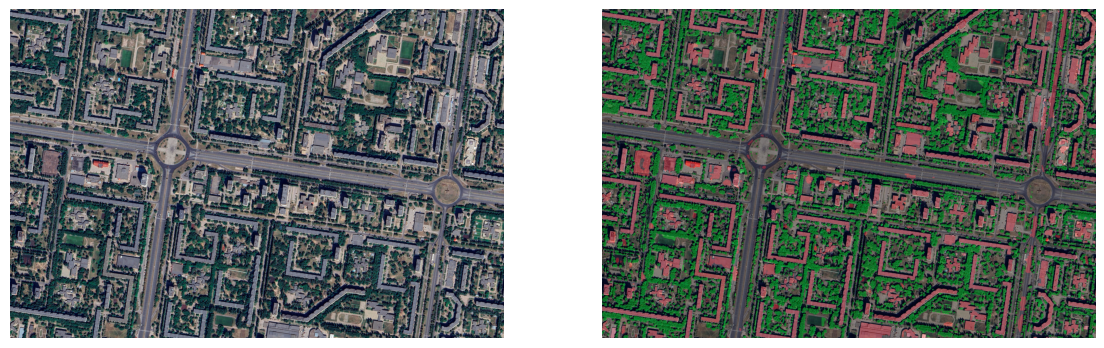

In [16]:
fig_1, ax_1 = plt.subplots(1, 2, figsize=(14, 5))

ax_1[0].axis('off')
ax_1[1].axis('off')

mask_b = tf.io.read_file('check\\big_tlt_check_250.png')
mask_b = tf.image.decode_png(mask_b, channels=3)
mask_b = tf.cast(mask_b, tf.uint8).numpy()
mask_b = np.array(mask_b) / 255.0


mask_t = tf.io.read_file('check\\big_tlt_check_100_t.png')
mask_t = tf.image.decode_png(mask_t, channels=3)
mask_t = tf.cast(mask_t, tf.uint8).numpy()
mask_t = np.array(mask_t) / 255.0

image = tf.io.read_file('check\\big_tlt_test.png')
image = tf.image.decode_png(image, channels=3)
image = tf.cast(image, tf.uint8).numpy()
image = np.array(image) / 255.0

ax_1[0].imshow(image)

mask_color_b = np.array([1, 0, 0])  
mask_color_t = np.array([0, 1, 0])  
alpha = 0.3

color_mask_b = mask_b * mask_color_b  
color_mask_t = mask_t * mask_color_t  
overlay = image * (1 - alpha) + color_mask_b * alpha  + color_mask_t * alpha

ax_1[1].imshow(overlay)


plt.imsave('check\\big_tlt_check_100_t_o.png', overlay)